### Импортируем библиотеки

In [1]:
#!pip install pandas-profiling[notebook]


In [2]:
import pandas as pd
from pandas import Series
import numpy as np
import pandas_profiling


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import mean_squared_error
from sklearn.metrics import auc, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score



from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
train = pd.read_csv('/kaggle/input/sf-dst-scoring/train.csv')
test= pd.read_csv('/kaggle/input/sf-dst-scoring/test.csv')

In [5]:
train.head(2)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0


Получим информацию о датасетах

In [6]:
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

(None, None)

In [7]:
train.columns, test.columns

(Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
        'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
        'region_rating', 'home_address', 'work_address', 'income', 'sna',
        'first_time', 'foreign_passport', 'default'],
       dtype='object'),
 Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
        'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
        'region_rating', 'home_address', 'work_address', 'income', 'sna',
        'first_time', 'foreign_passport'],
       dtype='object'))

Описания полей датасета

- client_id - идентификатор клиента
- education - уровень образования
- sex - пол заемщика
- age - возраст заемщика
- car - флаг наличия автомобиля
- car_type - флаг автомобиля иномарки
- decline_app_cnt - количество отказанных прошлых заявок
- good_work - флаг наличия “хорошей” работы
- bki_request_cnt - количество запросов в БКИ
- home_address - категоризатор домашнего адреса
- work_address - категоризатор рабочего адреса
- income - доход заемщика
- foreign_passport - наличие загранпаспорта
- sna - связь заемщика с клиентами банка
- first_time - давность наличия информации о заемщике
- score_bki - скоринговый балл по данным из БКИ
- region_rating - рейтинг региона
- app_date - дата подачи заявки
- default - флаг дефолта по кредиту

Итак, посмотрим на нашу целевую переменную

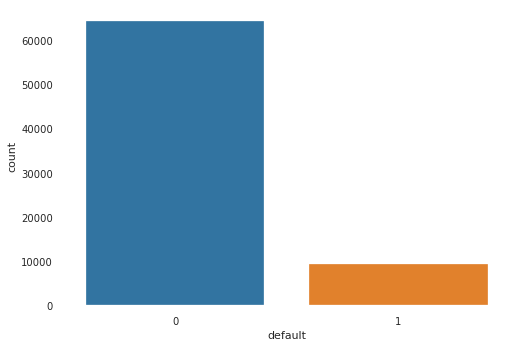

In [8]:
ax = sns.countplot(x="default", data=train)

In [9]:
train['default'].value_counts()

0    64427
1     9372
Name: default, dtype: int64

Дефолтных клиентов сильно меньше, чем недефолтных. Возможно, данных для модели будет мало. Может быть модель хорошо научится распознавать недефолтных и будет лажать на дефолтных. Посмотрим

Проверим наличие пропусков в датасете

In [10]:
train.isnull().sum(), test.isnull().sum()

(client_id             0
 app_date              0
 education           307
 sex                   0
 age                   0
 car                   0
 car_type              0
 decline_app_cnt       0
 good_work             0
 score_bki             0
 bki_request_cnt       0
 region_rating         0
 home_address          0
 work_address          0
 income                0
 sna                   0
 first_time            0
 foreign_passport      0
 default               0
 dtype: int64,
 client_id             0
 app_date              0
 education           171
 sex                   0
 age                   0
 car                   0
 car_type              0
 decline_app_cnt       0
 good_work             0
 score_bki             0
 bki_request_cnt       0
 region_rating         0
 home_address          0
 work_address          0
 income                0
 sna                   0
 first_time            0
 foreign_passport      0
 dtype: int64)

Для наглядности посмотрим на данный признак на графике

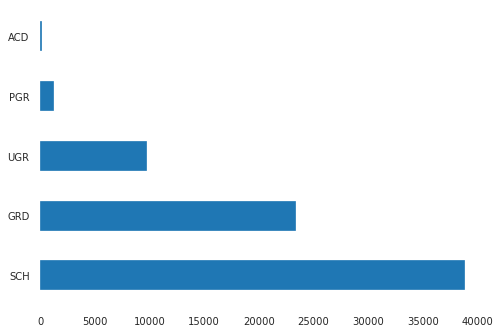

In [11]:
train['education'].value_counts().plot.barh()

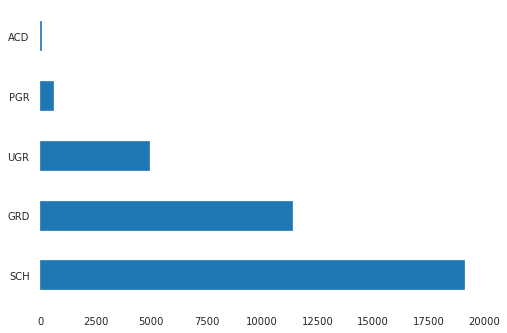

In [12]:
test['education'].value_counts().plot.barh()

Заполним пропуски самым часто встречающимся значением признака в тренировочной выборке

In [13]:
# fill NaN with the most frequent value

import collections

c_1 = collections.Counter(train['education'])
c_2 = collections.Counter(test['education'])

train['education'].fillna(c_1.most_common()[0][0], inplace=True)
test['education'].fillna(c_2.most_common()[0][0], inplace=True)

Проверим успешность заполнения

In [14]:
train.isnull().sum(), test.isnull().sum()

(client_id           0
 app_date            0
 education           0
 sex                 0
 age                 0
 car                 0
 car_type            0
 decline_app_cnt     0
 good_work           0
 score_bki           0
 bki_request_cnt     0
 region_rating       0
 home_address        0
 work_address        0
 income              0
 sna                 0
 first_time          0
 foreign_passport    0
 default             0
 dtype: int64,
 client_id           0
 app_date            0
 education           0
 sex                 0
 age                 0
 car                 0
 car_type            0
 decline_app_cnt     0
 good_work           0
 score_bki           0
 bki_request_cnt     0
 region_rating       0
 home_address        0
 work_address        0
 income              0
 sna                 0
 first_time          0
 foreign_passport    0
 dtype: int64)

На данный момент самый неудобный для анализа признак app_date - это, поскольку по своему типу это строка, но она содержит информацию о дате подачи заявки.
Преобразуем эту строку в формат дататайм

In [15]:
train.app_date.head(5), test.app_date.head(5)

(0    01FEB2014
 1    12MAR2014
 2    01FEB2014
 3    23JAN2014
 4    18APR2014
 Name: app_date, dtype: object,
 0    22MAR2014
 1    24JAN2014
 2    23MAR2014
 3    03FEB2014
 4    04FEB2014
 Name: app_date, dtype: object)

Сконветируем формат даты к удобному для работы

In [16]:
# Конвертируем признаки в формат datatime

train.app_date = pd.to_datetime(train.app_date)
test.app_date = pd.to_datetime(train.app_date)
print(train.app_date.head(2))
print(test.app_date.head(2))

0   2014-02-01
1   2014-03-12
Name: app_date, dtype: datetime64[ns]
0   2014-02-01
1   2014-03-12
Name: app_date, dtype: datetime64[ns]


In [17]:
train.head(2)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,2014-02-01,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,2014-03-12,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0


На основе признака app_date создадим новые признаки

In [18]:
current_date = pd.to_datetime('08FEB2021')

# Количество дней, прошедших со дня подачи заявки

train['days_passed'] = (current_date - train.app_date).dt.days
test['days_passed'] = (current_date - test.app_date).dt.days

# Месяц подачи заявки

train['app_date_month'] = train.app_date.dt.month
test['app_date_month'] = test.app_date.dt.month

# День недели, в который была подана заявка

train['app_date_weekday'] = train.app_date.dt.weekday
test['app_date_weekday'] = test.app_date.dt.weekday

ДОбавим новый признак в датафрейм. Я думаю есть смысл выяснить, привела ли выданная в тот или иной день заявка к дефолту

In [19]:
#Выясняем общее кол-во заявок, закончившихся дефолтом по дням
num_of_def_train = train['app_date'][train['default']==1].value_counts()
num_of_def_train

2014-01-28    129
2014-03-17    129
2014-01-23    122
2014-03-18    121
2014-04-02    119
             ... 
2014-04-20     25
2014-01-03     24
2014-04-13     20
2014-01-02     18
2014-01-01      6
Name: app_date, Length: 120, dtype: int64

In [20]:
num_of_apps=train['app_date'].value_counts()
num_of_apps

2014-03-18    1018
2014-03-17     911
2014-03-19     909
2014-03-31     904
2014-04-07     882
              ... 
2014-04-20     243
2014-01-07     228
2014-01-03     193
2014-01-02     137
2014-01-01      43
Name: app_date, Length: 120, dtype: int64

In [21]:
perc_of_def_app=num_of_def_train/num_of_apps*100

Мы вычислилил процент выдачи дефолтных заявок в этот день

In [22]:
perc_of_def_app

2014-01-01    13.953488
2014-01-02    13.138686
2014-01-03    12.435233
2014-01-04    17.586207
2014-01-05    12.000000
                ...    
2014-04-26     9.882353
2014-04-27    12.349398
2014-04-28     8.983051
2014-04-29     9.139785
2014-04-30    10.787671
Freq: D, Name: app_date, Length: 120, dtype: float64

In [23]:
dic=[]
for date in train['app_date']:
    dic.append(perc_of_def_app[date])    
train['perc_of_def_app']=dic

In [24]:
dic=[]
for date in test['app_date']:
    dic.append(perc_of_def_app[date])    
test['perc_of_def_app']=dic

Посмотрим еще разок на преобразованные данные потому что можем)
Заодно определимся, какие из признаков категориальные, какие числовые, а какие бинарные. Не то, чтобы это было не очевидно, но все равно посмотрим.

In [25]:
#pandas_profiling.ProfileReport(data)

Так, вижу много коррелирующихся признаков, в основном тех, которые я добавила самостоятельно. Непорядок. Дальше, наверное, уберу их.
Также, я определилась, куда добавлю region_rating - в числовые признаки.

In [26]:
data = pd.concat([train, test])

Теперь разобъем все признаки на три типа( категориальные, бинарные и числовые)

In [27]:
data.nunique().sort_values(ascending= False)

client_id           110148
score_bki           102618
income                1207
app_date               120
perc_of_def_app        120
days_passed            120
age                     52
bki_request_cnt         40
decline_app_cnt         24
region_rating            7
app_date_weekday         7
education                5
sna                      4
app_date_month           4
first_time               4
work_address             3
home_address             3
sex                      2
foreign_passport         2
car                      2
car_type                 2
default                  2
good_work                2
dtype: int64

In [28]:
# Выведем ключи для удобства копирования наименований признаков
data.nunique().sort_values(ascending= False).keys()

Index(['client_id', 'score_bki', 'income', 'app_date', 'perc_of_def_app',
       'days_passed', 'age', 'bki_request_cnt', 'decline_app_cnt',
       'region_rating', 'app_date_weekday', 'education', 'sna',
       'app_date_month', 'first_time', 'work_address', 'home_address', 'sex',
       'foreign_passport', 'car', 'car_type', 'default', 'good_work'],
      dtype='object')

Признаки с большим количеством уникальных значений можно отнести к числовым, кроме app_date, его надо преобразовать, поскольку это дата. Все признаки с умеренным кол-вом признаков отнесем к категриальным. Пока не понятно, что за переменная sna, но по кол-ву значений отнесем ее к категориальным переменным. Все признаки с двумя значениями отнесем к бинарным( внезапно =)) Также, скорее всего, стоит сразу выкинуть столбец client_id, поскольку он не несет никакой, очевидной для меня на данном этапе, нагрузки.

Полученные признаки сгруппируем в три категории по типу их обработки (категориальные, бинарные и числовые) для дальнейшего удобного анализа.

In [29]:
train.head(2)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,work_address,income,sna,first_time,foreign_passport,default,days_passed,app_date_month,app_date_weekday,perc_of_def_app
0,25905,2014-02-01,SCH,M,62,Y,Y,0,0,-2.008753,...,2,18000,4,1,N,0,2564,2,5,11.623616
1,63161,2014-03-12,SCH,F,59,N,N,0,0,-1.532276,...,3,19000,4,1,N,0,2525,3,2,11.940299


In [30]:
#Итак, числовые признаки
num_cols = ['score_bki', 'income', 'days_passed', 'age','bki_request_cnt', 'decline_app_cnt', 'region_rating','perc_of_def_app']
#Бинарные признаки
bin_cols = ['sex', 'good_work','car', 'car_type', 'foreign_passport']
#Категориальные признаки:
cat_cols=['education','sna', 'first_time', 'app_date_month','app_date_weekday','work_address', 'home_address']

## Визуализация

Очевидно что выборка распределена неравномерно и недефолтных клиентов заметно больше

Построим графики распределения численных переменных

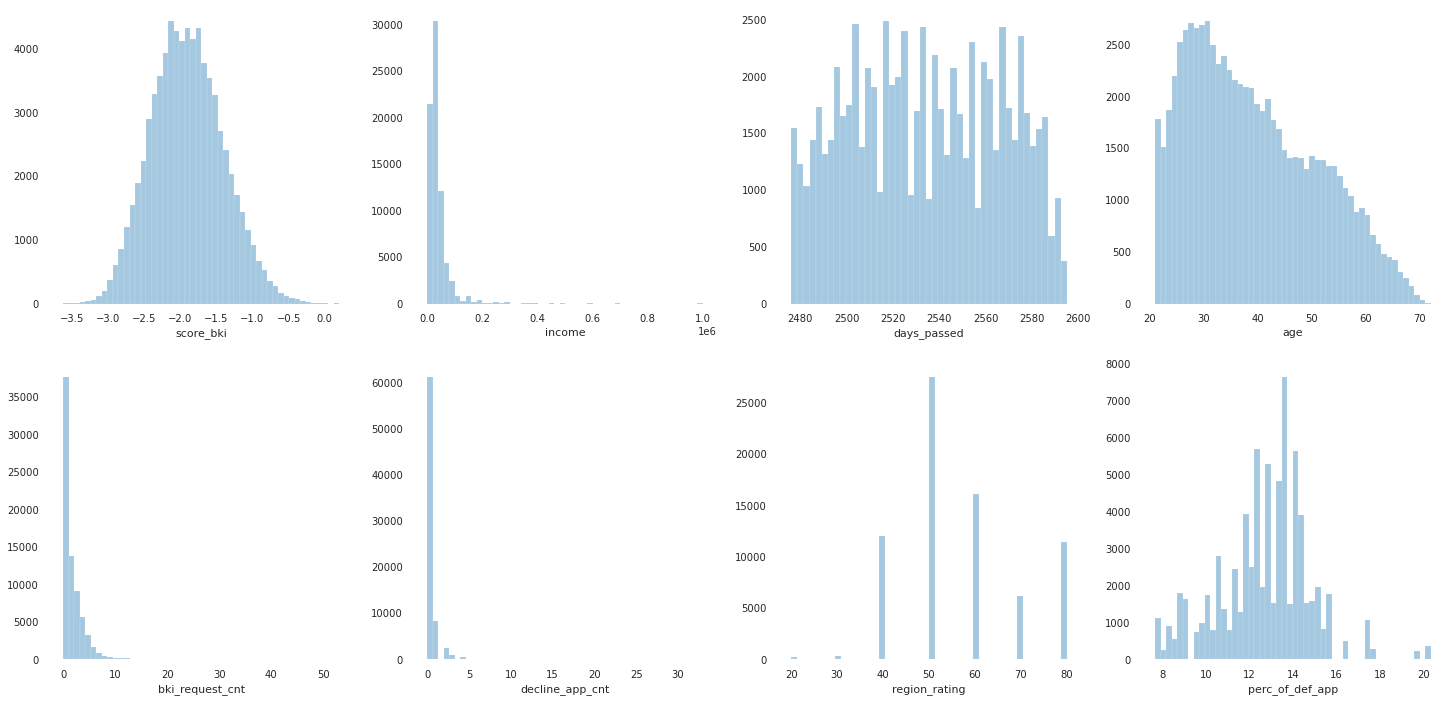

In [31]:
fig, axes = plt.subplots(2, 4, figsize=(25,12))
for col, i in zip(num_cols, range(8)):
    sns.distplot(train[col], kde=False, ax=axes.flat[i])

Выводы по числовым признакам:
Score_bki(скоринговый балл): признак распределен нормально. В интернете я нашла информацию о том, что есть несколько шкал оценки скорингового балла.

1–900;
1–1300;
300–850.
https://www.sravni.ru/enciklopediya/info/skoringovyi-ball/
Также нашла информацию о том, что он может быть отрицательным, например у сбербанка ( у них, судя по информации, минимальный скоринговый балл равен -111)
В любом случае, я делаю вывод, что здесь какая-то своя модель подсчта скорингового балла. Не буду трогать этот столбик, у него нормальное распределение. Пусть будет так, как он есть сейчас.

income: доход клиентов варьируется от 1000 до 1000000 с медианным показателем 30000. Логарифмируем его далее.

app_passed_days (количество дней с начала 2014 до даты подачи заявки): в нашем датасете находятся данные только за первые 4 месяца 2014 года, количество заявок по дням примерно равномерное за исключением начала и окончания периода. В начале и конце периода заявок несколько меньше. Распределение нормальное.

age: график распределения возраста смещен вправо. Попробую логарифмировать этот признак.

bki_request_cnt (количество запросов в БКИ): распределение признака сильно смещено вправо. Попробую логарифмировать признак далее.

decline_app_cnt (количество отказанных прошлых заявок): распределение также смещено вправо. Попробую логарифмировать признак далее.

region_rating: Я бы сказала, что он имеет нормальное распределение, попробую логарифмировать все равно
perc_of_def_app: Распределение нормальное, оставляем, как есть

Прологарифмируем переменные, которые вызывают вопросы в распределении

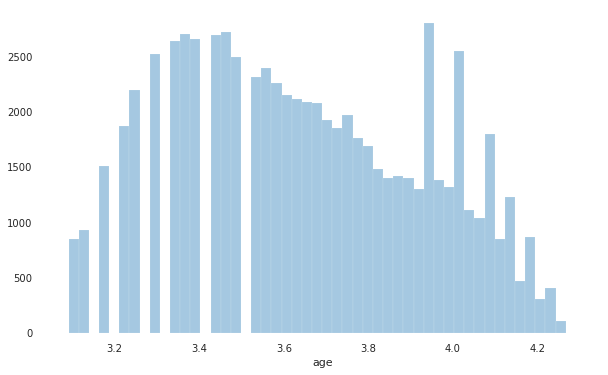

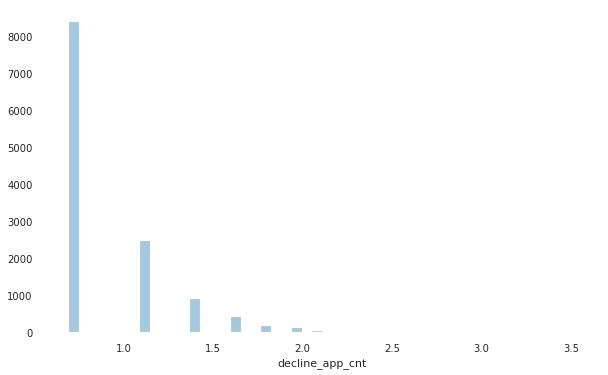

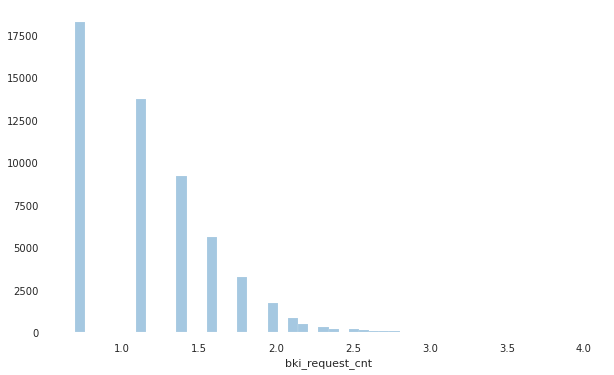

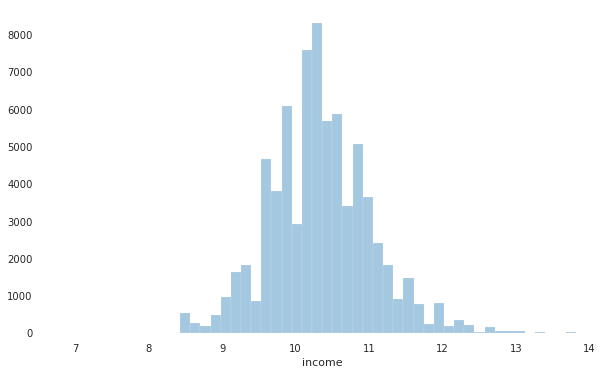

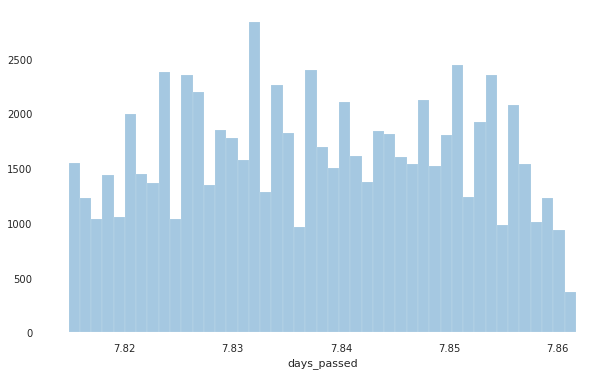

In [32]:
num_cols_log = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'days_passed']
for i in num_cols_log:
    train[i] = np.log(train[i] + 1)
    plt.figure(figsize=(10,6))
    sns.distplot(train[i][train[i] > 0].dropna(), kde = False, rug=False)
    plt.show()

Ну, income  и age вроде бы стале выглядеть лучше)

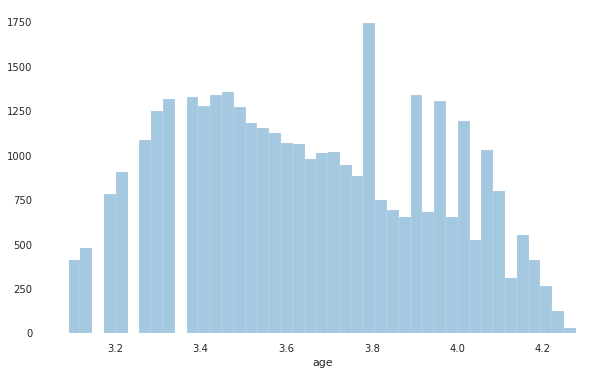

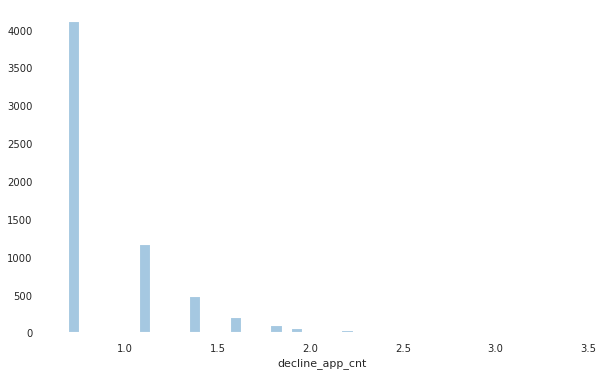

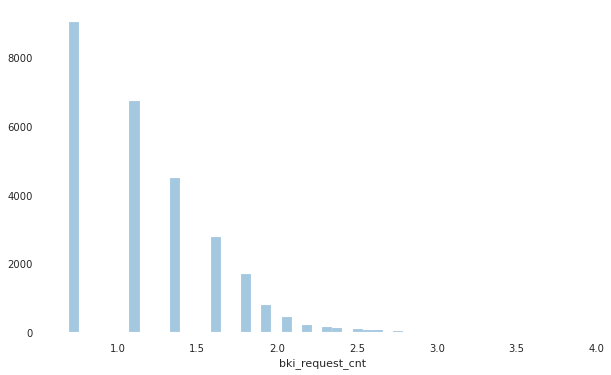

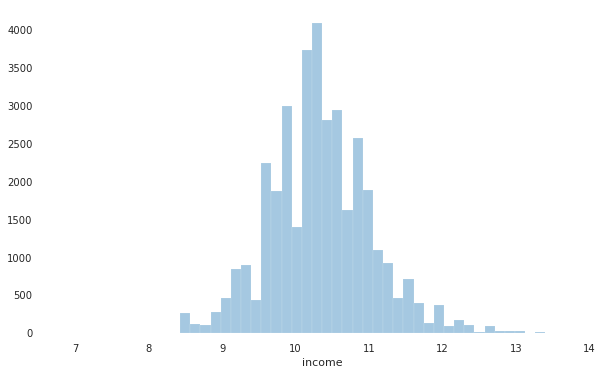

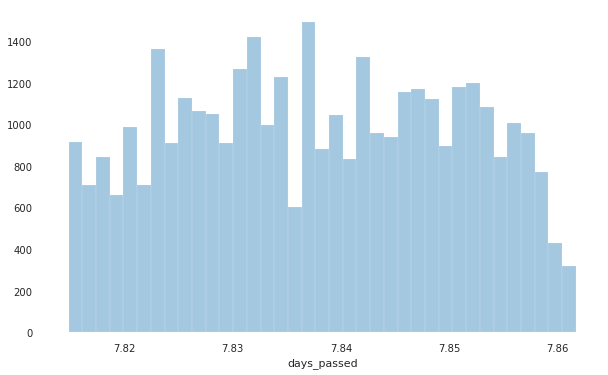

In [33]:
for i in num_cols_log:
    test[i] = np.log(test[i] + 1)
    plt.figure(figsize=(10,6))
    sns.distplot(test[i][test[i] > 0].dropna(), kde = False, rug=False)
    plt.show()

Построим матрицу корреляций

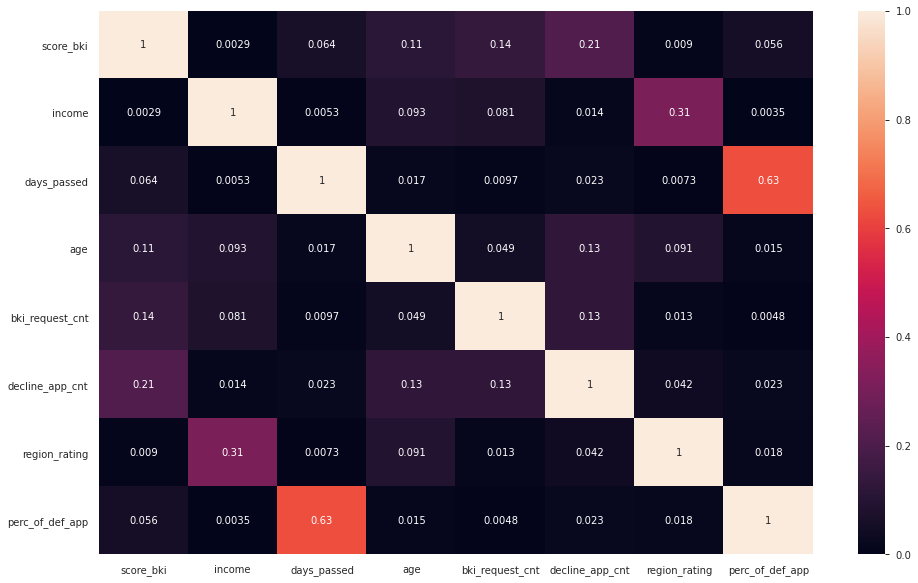

In [34]:
plt.figure(figsize=(16,10))
sns.heatmap(train[num_cols].corr().abs(), vmin=0, vmax=1, annot=True)

Наблюдается довольно высокая коррлеряция между days_passed  и вероятностью выдачи дефолтной заявки в этот день. В принципе логично)

Высокой корреляции между остальными признаками не наблюдается. Есть небольша корреляция между рейтингом региона и доходом, что, в целом логично, средняя зарплата в Москве будет выше, чем в Нижнем Новгороде)

Проанализируем боксплоты для численных переменных

In [35]:
num_cols

['score_bki',
 'income',
 'days_passed',
 'age',
 'bki_request_cnt',
 'decline_app_cnt',
 'region_rating',
 'perc_of_def_app']

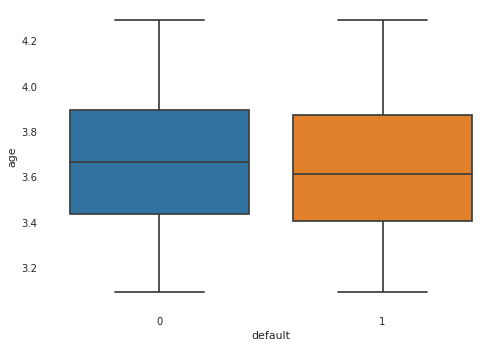

In [36]:
sns.boxplot(x=train.default, y=train.age)

Недефолтные клиенты в среднем старше дефолтных

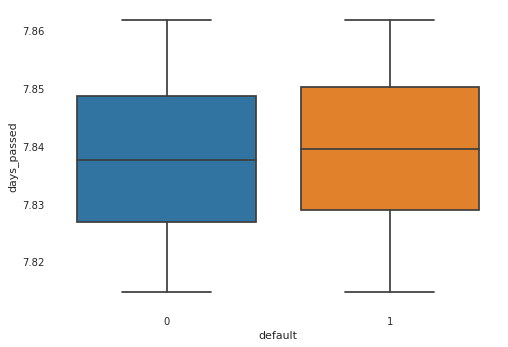

In [37]:
sns.boxplot(x=train.default, y=train.days_passed)

Дефолтные клиенты в среднем оформляли заявки раньше, чем недефолтные. Но разница незначительная.

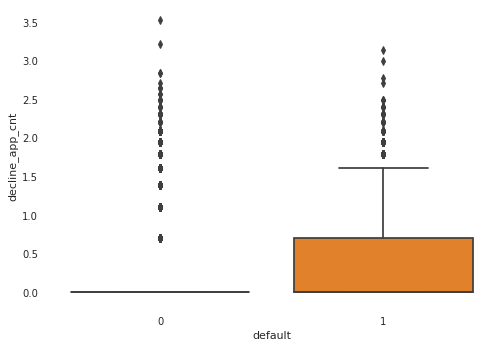

In [38]:
sns.boxplot(x=train.default, y=train.decline_app_cnt)

У дефолтных клиентов количество отклоненных заявок выше, чем у недефолтных. Судя по графикам, принятие заявки скорее является исключительной ситуацией(выборосом).

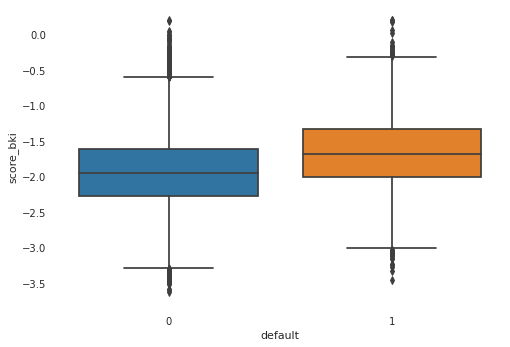

In [39]:
sns.boxplot(x=train.default, y=train.score_bki)

Скоринговый балл в среднем выше у дефолтных клиентов, что довольно необычно (вероятнее всего банк самостоятельно произвел манипуляции с этим признаком, т. к. обычно скоринговый балл положительный от 0 до 850)

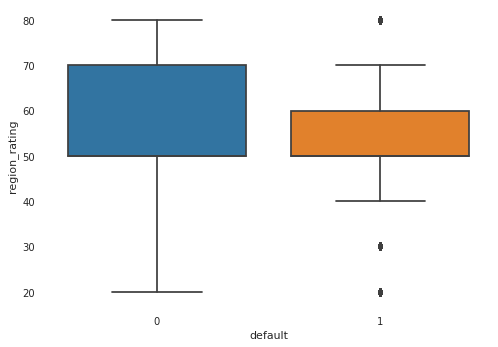

In [40]:
sns.boxplot(x=train.default, y=train.region_rating)

Среднее значение в данном случае больше у недефолтных клиентов, в то время как медианы равны

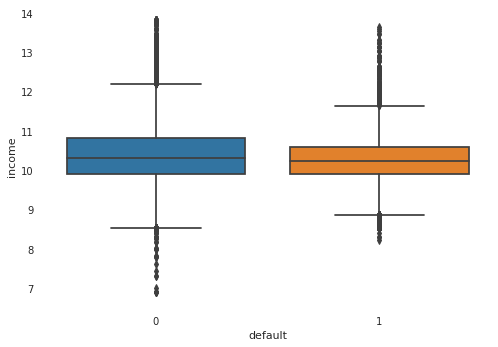

In [41]:
sns.boxplot(x=train.default, y=train.income)

Доход недефолтных клиентов выше, чем доход дефолтных. Хотя средний показатель примерно один и тот же.

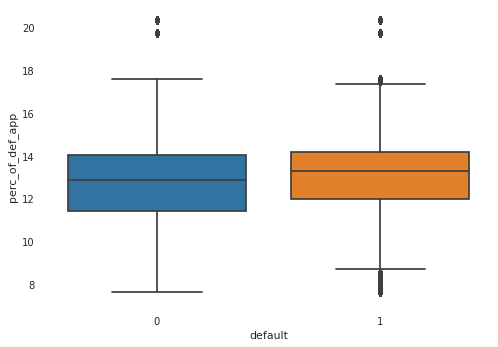

In [42]:
sns.boxplot(x=train.default, y=train.perc_of_def_app)

В целом боксплот выглядит логично. В среднем дефолтов больше, если процент выдачи дефолтной заявки в этот день больше

Посмотрим внимательнее на бинарные и категориальные признаки. Опытным путем я выяснила, что боксплоты - не лучший вариант) Поэтому построим другие графики

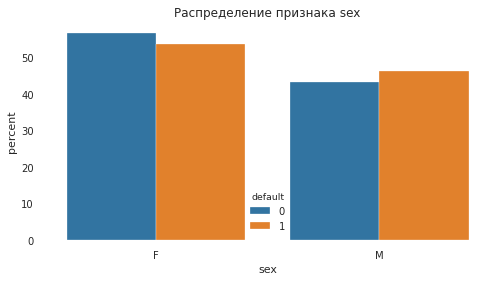

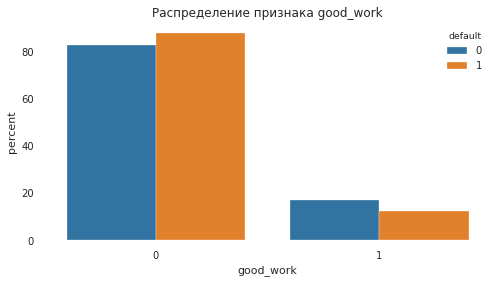

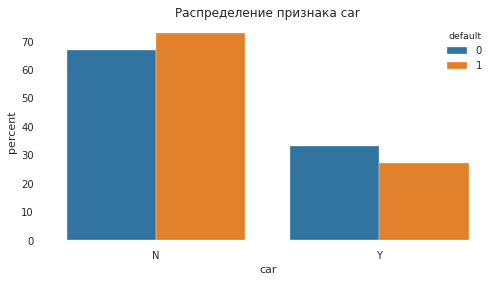

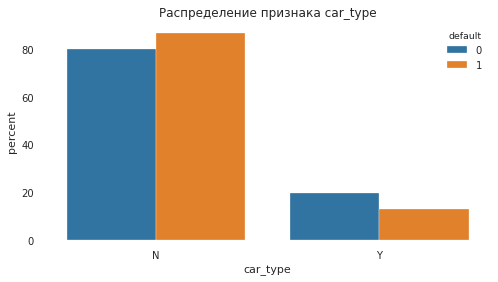

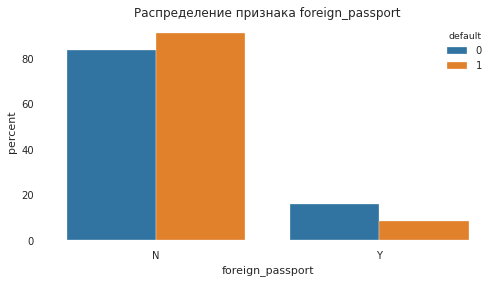

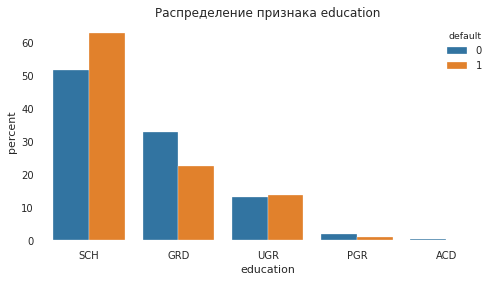

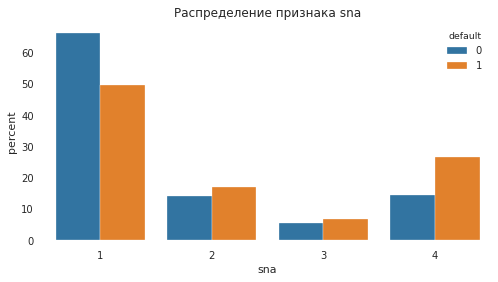

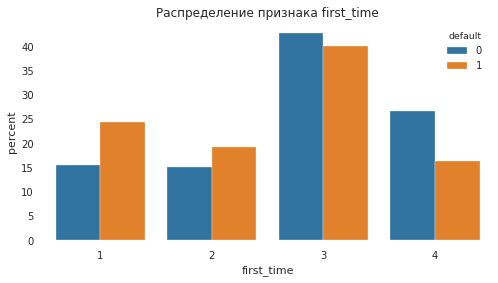

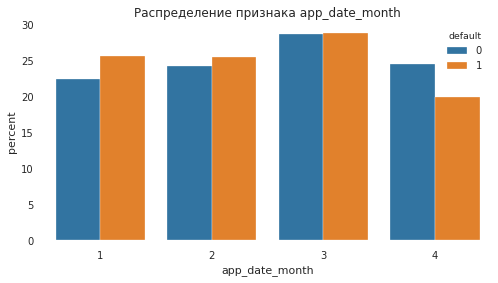

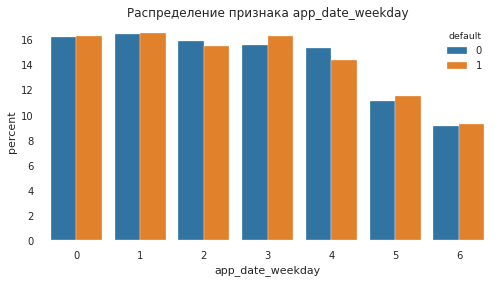

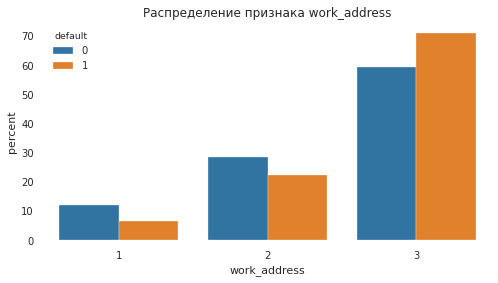

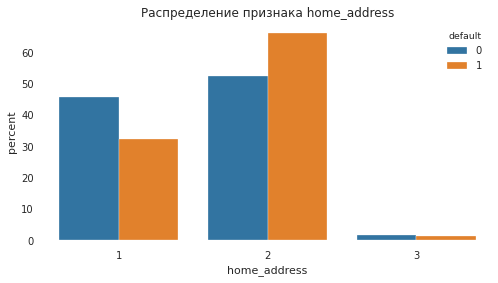

In [43]:
for col in (bin_cols + cat_cols):
    plt.figure(figsize=(8, 4))
    prop_df = train[col].groupby(train["default"]).value_counts(normalize=True).rename("percent").reset_index()
    prop_df["percent"] *= 100
    sns.barplot(x=col, y="percent", hue="default", data=prop_df)
    plt.title(f"Распределение признака {col}")

*Sex* - Женщин в датасете больше, но женщин банкротов-меньше, чем женщин небанкротов. Что касается мужчин, то среди мужчин вернувших кредит меньше чем невернувших
*Goodwork* - По общему числу делаю вывод, что наличие хорошей работы наблюдается у меньшего кол-ва людей из имеющися данных. Наверное, хорошая работа в большинстве случаев позволяет обойтись без кредитов, да и вернувших кредит среди них гораздо больше чем среди людей, у которых нет этого флажка.
*Car* - Наличие машины говорит о том, что человек более кредитоспособен по сравнению с тем у кого машины нет. Логично)
*Car_type*- Люди с иномарками оказались более кредитоспособными, что логично, иномарки дороже) Правда, я не могу сказать, что этот вывод достаточно обоснован, поскольку не знаю, в какой стране собраны данные.
*Foreign passport*- владельцы загран паспортов - более надежные заемщики. Скорее всего это связано с тем, что частая причина для оформления заграна - путешествия. Путешествующие люди более обеспечены.
*Education* - Самые неблагонадежные заемщики- люди с образованием не выше школьного. У закончивших высшее процент отданных кредитов самый высокий. Студенты не вернут или вернут кредит с вероятностью приблизительно 55/45, аспиранты скорее вернут, чем не вернут,  кандидаты наук скорее вернут кредит.В общем и целом наблюдается тенденция, что чем выше уровень образования заемщика, тем охотнее он вернет кредит.
*SNA* - самый непонятный на данный момент параметр, в общем чате подсказали, что это степень отношений заемщика с другим клиентом банка. Предположу, что 1 означает высокую степень родства. Только если заемщик является близким родственником другого клиента банка риск дефолта ниже, в остальных случаях он увеличивается.
*first_time* (давность наличия информациии о заемщике)- Не совсем поняла, что соответствует числоам от одного до четырех, но судя по данным, чем этот параметр больше, тем больше вероятность, что кредит будет выплачен банку.
*app_date_month*- Месяц подачи заявки. Я подумала, что в январе потребность кредита может возникнуть у неблагонадежных заемщиков, поскольку они прокутили все деньги на новый год и теперь им надо пополнять запасы. Кредит в таком случае -мера спонтанная, необдуманная, может привести к нежелательным последствиям. В целом моя догадка подтвердилась) Чем дальше от нового года, тем охотнее отдают кредиты.
*app_date_weekday*- Этот параметр также добавлен самостоятельно. Я подумала, что займы, взятые в пятницу могут быть не выплачены в срок, поскольку взяты перед выходными и могут пойти на необдуманные, спонтанные траты, как, собственно и займы в выходные. В целом, оказалась права, но не думаю, что в дальнейшем этот признак что-то даст)
*work_address* - Третьей категории кредиты лучше не давать.
*home_address* - Второй категории кредиты лучше не давать.

## Преобразование бинарных и категориальных переменных

Преобразуем бинарные переменные при помощи класса LabelEncoder

In [44]:
label_encoder = LabelEncoder()

for column in bin_cols:
    train[column] = label_encoder.fit_transform(train[column])
    test[column] = label_encoder.fit_transform(test[column])

    
# убедимся в преобразовании    
display(train.head())
display(test.head())

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,work_address,income,sna,first_time,foreign_passport,default,days_passed,app_date_month,app_date_weekday,perc_of_def_app
0,25905,2014-02-01,SCH,1,4.143135,1,1,0.000000,0,-2.008753,...,2,9.798183,4,1,0,0,7.849714,2,5,11.623616
1,63161,2014-03-12,SCH,0,4.094345,0,0,0.000000,0,-1.532276,...,3,9.852247,4,1,0,0,7.834392,3,2,11.940299
2,25887,2014-02-01,SCH,1,3.258097,1,0,1.098612,0,-1.408142,...,2,10.308986,1,4,1,0,7.849714,2,5,11.623616
3,16222,2014-01-23,SCH,0,3.988984,0,0,0.000000,0,-2.057471,...,3,9.210440,1,3,0,0,7.853216,1,3,17.354196
4,101655,2014-04-18,GRD,1,3.891820,0,0,0.000000,1,-1.244723,...,3,10.308986,1,4,1,0,7.819636,4,4,7.866868


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,home_address,work_address,income,sna,first_time,foreign_passport,days_passed,app_date_month,app_date_weekday,perc_of_def_app
0,74835,2014-02-01,GRD,1,3.401197,1,1,0.000000,0,-2.271884,...,1,2,10.819798,1,4,0,7.849714,2,5,11.623616
1,17527,2014-03-12,SCH,0,3.688879,0,0,1.791759,0,-1.504999,...,1,2,8.517393,4,3,0,7.834392,3,2,11.940299
2,75683,2014-02-01,UGR,1,3.931826,1,1,0.000000,0,-1.691339,...,1,2,10.308986,1,3,1,7.849714,2,5,11.623616
3,26883,2014-01-23,SCH,1,4.043051,0,0,0.000000,0,-2.374182,...,1,2,9.741027,1,3,0,7.853216,1,3,17.354196
4,28862,2014-04-18,GRD,0,3.663562,0,0,0.000000,0,-2.487502,...,2,3,11.695255,1,3,0,7.819636,4,4,7.866868


Преобразуем категориальные переменные при помощи OneHotEncoder

In [45]:
x_cat = OneHotEncoder(sparse = False).fit_transform(train[cat_cols].values)
y_cat = OneHotEncoder(sparse = False).fit_transform(test[cat_cols].values)

print(x_cat.shape)
print(y_cat.shape)

(73799, 30)
(36349, 30)


In [46]:
education_dummy = pd.get_dummies(train['education'])
education_dummy_test = pd.get_dummies(test['education'])
education_dummy.head()

,ACD,GRD,PGR,SCH,UGR
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,1,0
3,0,0,0,1,0
4,0,1,0,0,0


Посмотрю напоследок корреляцию

In [47]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   client_id         36349 non-null  int64         
 1   app_date          36349 non-null  datetime64[ns]
 2   education         36349 non-null  object        
 3   sex               36349 non-null  int64         
 4   age               36349 non-null  float64       
 5   car               36349 non-null  int64         
 6   car_type          36349 non-null  int64         
 7   decline_app_cnt   36349 non-null  float64       
 8   good_work         36349 non-null  int64         
 9   score_bki         36349 non-null  float64       
 10  bki_request_cnt   36349 non-null  float64       
 11  region_rating     36349 non-null  int64         
 12  home_address      36349 non-null  int64         
 13  work_address      36349 non-null  int64         
 14  income            3634

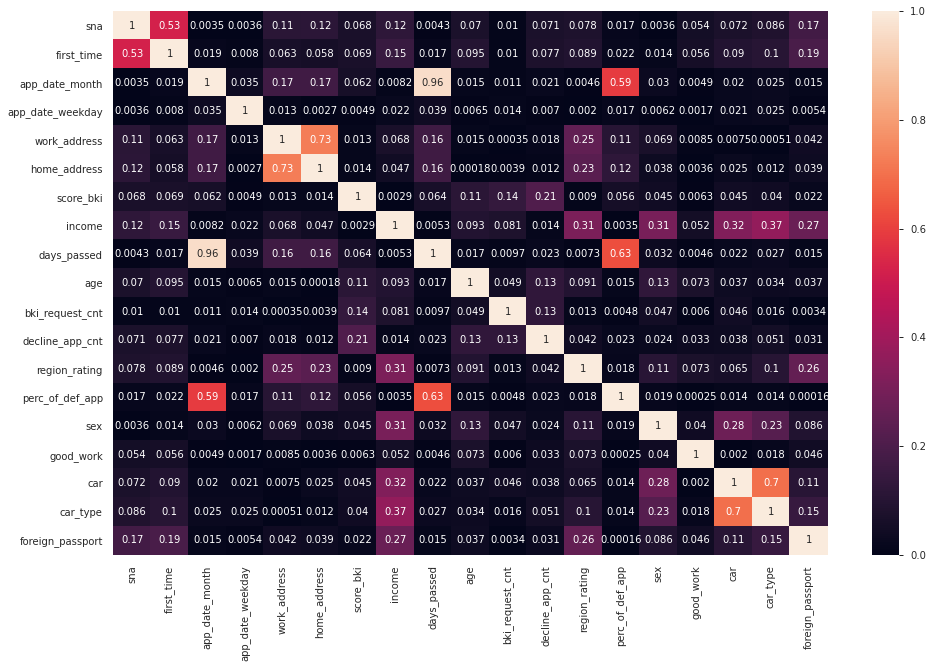

In [48]:
plt.figure(figsize=(16,10))
sns.heatmap(train[cat_cols+num_cols+bin_cols].corr().abs(), vmin=0, vmax=1, annot=True)

Есть сильная корреляция между некоторыми признаками, но я их не буду удалять, у меня результаты порятятся)

## Значимость числовых переменных

Text(0.5, 0, 'F-value')

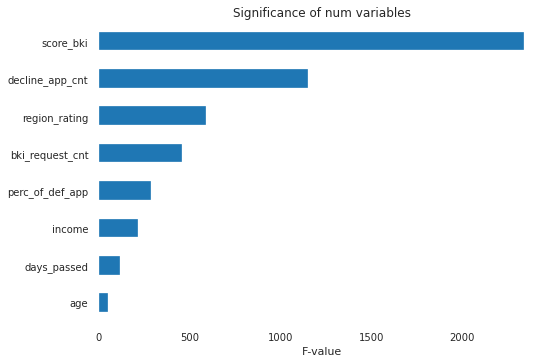

In [49]:
imp_num = Series(f_classif(train[num_cols], train['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')
plt.title('Significance of num variables')
plt.xlabel('F-value')

## Значимость бинарных и категориальных переменных

Text(0.5, 1.0, 'Significance of bin variables')

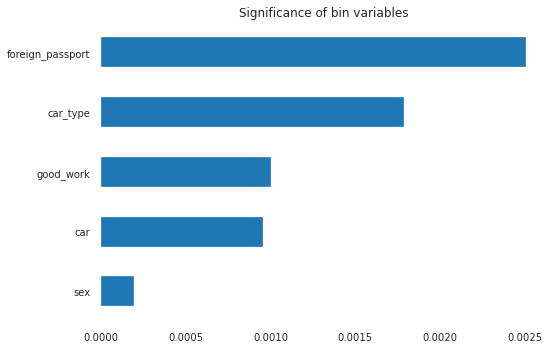

In [51]:
# Значимость бинарных признаков

imp_bin = Series(mutual_info_classif(train[bin_cols], train['default'],
                                     discrete_features =True), index = bin_cols)
imp_bin.sort_values(inplace = True)
imp_bin.plot(kind = 'barh')
plt.title('Significance of bin variables')

Ничего не буду удалять, туда-сюда перезапускала ноутбук с разными комбинациями данных, по итогу лучший результат был, когда ничего не удаляла)

Text(0.5, 1.0, 'Significance of cat variables')

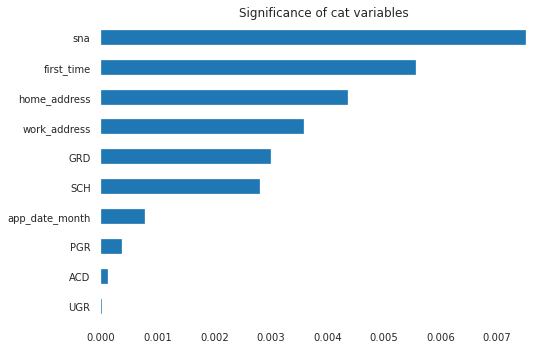

In [53]:
# Значимость категориальных признаков

new_cat_cols = ['app_date_month', 'home_address', 'work_address', 'sna', 'first_time']

imp_cat = pd.Series(mutual_info_classif(pd.concat([train[new_cat_cols], education_dummy], axis=1),
                                        train['default'], discrete_features =True),
                    index = pd.concat([train[new_cat_cols], education_dummy], axis=1).columns)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')
plt.title('Significance of cat variables')

Значение разных типов образования по-разному влияет на вероятность дефолта. Наибольший вклад вносят люди с образованием "GRD". Удалять я его не хочу, там довольно много значений, пусть останется)

## Подготовка данных к машинному обучению

Добавим дополнительные принаки в наш датафрейм. Больше признаков богу признаков!

In [54]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)

x_tr = poly.fit_transform(train[num_cols].values)
y_test = poly.fit_transform(test[num_cols].values)

Стандартизируем числовые переменные

In [55]:
# Scaling num variables

x_num = StandardScaler().fit_transform(x_tr)
y_num = StandardScaler().fit_transform(y_test)
print(x_num)
print(y_num)

[[ 0.         -0.2087987  -0.78501579 ... -0.56439672 -0.67954831
  -0.57383781]
 [ 0.          0.74754461 -0.70752611 ... -0.56439672 -0.60198179
  -0.43345417]
 [ 0.          0.99669566 -0.05288771 ...  1.91366223  1.02866886
  -0.57383781]
 ...
 [ 0.          0.78696739  0.5282444  ...  1.91366223  0.0361117
  -1.5608108 ]
 [ 0.          0.85380611 -1.25140899 ... -0.56439672  0.7808979
   2.70265507]
 [ 0.          0.28102087 -0.31419734 ... -0.56439672  0.72407042
   2.55015114]]
[[ 0.         -0.73288746  0.68282058 ... -0.56902243 -0.68196696
  -0.57267559]
 [ 0.          0.79551047 -2.63253397 ... -0.56902243 -0.6046915
  -0.43170801]
 [ 0.          0.42413578 -0.05272498 ... -0.56902243 -0.68196696
  -0.57267559]
 ...
 [ 0.          1.92005304  0.9453502  ... -0.56902243 -1.00893053
  -1.12719725]
 [ 0.          1.31888606 -0.05272498 ...  1.90270276  1.12230127
  -0.45612458]
 [ 0.          0.79042787 -1.05077617 ... -0.56902243 -0.57493176
  -0.37640906]]


И объединим стандартизованные числовые, бинарные и закодированные категориальные переменные в одно признаковое пространство, разделив при этом признаки и целевую переменную.

In [56]:
# Merge

X = np.hstack([x_num, train[bin_cols].values, x_cat])
Y = train['default'].values

id_test = test.client_id
test = np.hstack([y_num, test[bin_cols].values, y_cat])

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42, shuffle = True)

## Регуляризация

Сначала реализуем GridSearch, что также было предложено на портале.
Погуглив я нашла еще два вида регуляризации для логистической регресии, но этот оказался пока самым понятным)

не скомпилилась у меня эта строчка в каггл =()
model = LogisticRegression(random_state=42)

iter_max = 100

param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_max]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_max]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_max]},
]

gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_
print(model)

In [58]:
from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(-2, 3, 4)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l2
Лучшее C: 0.01


In [84]:
logreg = LogisticRegression(C=1006).fit(X_train, y_train)
print("Правильность на обучающей выборке: {:.5f}".format(logreg.score(X_train, y_train)))
print("Правильность на тестовой выборке: {:.5f}".format(logreg.score(X_test, y_test)))

Правильность на обучающей выборке: 0.87263
Правильность на тестовой выборке: 0.87385


Все хорошо, модель не переобучилась, данных тоже хватило

Обучим модель

In [85]:
lgr = LogisticRegression(penalty = 'l2', C=1006, max_iter=500)
lgr.fit(X_train, y_train)
pred=lgr.predict(X_test)
probs = lgr.predict_proba(X_test)
probs = probs[:,1]

Почему я выбрала такой С, а не тот, что мне показал GridSearchCV? Да рандомно подбирала и подобрала вот такой. Это лучший результат, которй я смогла выбить на данном этапе)

In [86]:
def roc_auc_plot(y_true, y_pred_proba):

    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    
    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.5f}')
    plt.title('ROC AUC = %0.3f' % roc_auc, fontsize=15)
    plt.xlabel('False positive rate (FPR)', fontsize=15)
    plt.ylabel('True positive rate (TPR)', fontsize=15)
    plt.legend(fontsize=15, loc = 'lower right')

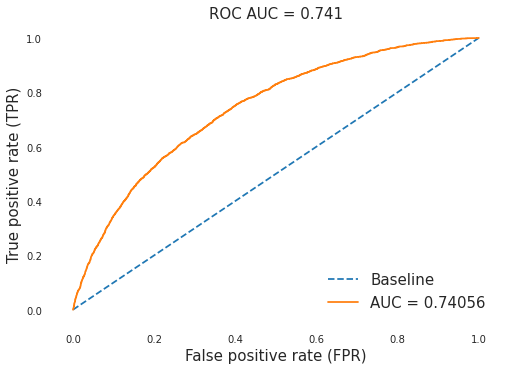

In [87]:
roc_auc_plot(y_test,probs)

In [88]:
print("Test MSE = %.4f" % mean_squared_error(y_test, probs, squared=False))
print("Test RMSE = %.4f" % mean_squared_error(y_test, probs, squared=True))

Test MSE = 0.3163
Test RMSE = 0.1001


В целом, значения RMSE  меня устраивают, метрика среднеквадратичной ошибки довольно низкая, хоть и не идеальная

In [89]:
precision, recall, thresholds = precision_recall_curve(y_test, probs)

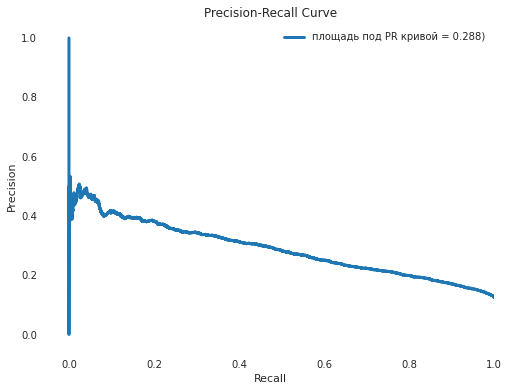

In [90]:
plt.figure(figsize=(8, 6))
prc_area = auc(recall, precision)
plt.plot(recall, precision, lw=3, label='площадь под PR кривой = %0.3f)' % prc_area)
    
plt.xlim([-.05, 1.0])
plt.ylim([-.05, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()

Точность, с ходом времени падает

Посмотрим, сколько же мы угадали на самом деле

In [91]:
conf_mat = confusion_matrix(y_test, pred).T
print('Confusion matrix:\n{}'.format(conf_mat))

Confusion matrix:
[[19272  2704]
 [   88    76]]


Судя по всему, мы хорошо угадали недефолтных клиентов и плохо угадали дефолтных.Ошибка второго рода не решена, пока не знаю, как бы это можно было исправить) Подскажите)

Обучим модель на всем датасете

In [94]:
lgr = LogisticRegression(penalty = 'l2', C=1006, max_iter=500)
lgr.fit(X, Y)
probs = lgr.predict_proba(test)
probs = probs[:,1]

In [95]:
my_submission = pd.DataFrame({'client_id': id_test, 
                            'default': probs})
my_submission.to_csv('submission.csv', index=False)

my_submission

,client_id,default
0,74835,0.039994
1,17527,0.347792
2,75683,0.066355
3,26883,0.100564
4,28862,0.009524
...,...,...
36344,83775,0.406229
36345,106254,0.016129
36346,81852,0.262233
36347,1971,0.185012
